<img src="https://static.wixstatic.com/media/66c28f_db7a1ba3e35b4b17a6688472c889b7bf~mv2_d_2777_1254_s_2.png/v1/fill/w_710,h_320,al_c,q_85,usm_0.66_1.00_0.01/logo_yellow_white.webp" width=1000, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

# Text Summarization

Всем привет! Сегодня мы познакомимся с задачей суммаризации текста на примере генерации "сжатых" новостей. Рассмотрим некоторые базовые решения и познакомимся с архитектурами нейросетей для решения задачи.
Датасет: gazeta.ru


`Ноутбук создан на основе семинара Гусева Ильи на кафедре компьютерной лингвистики ABBYY МФТИ.`

Загрузим датасет и необходимые библиотеки

In [ ]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [ ]:
!pip -q install razdel networkx pymorphy2 nltk rouge==0.3.1 summa 

## Dataset

Посмотрим на то, как устроен датасет

In [1]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

"head" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.
"cat" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.
"cat" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.
"cat" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


In [1]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r", encoding="utf-8") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [2]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [3]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

## Extractive RNN

### BPE
Для начала сделаем BPE токенизацию

In [ ]:
!pip install youtokentome

In [4]:
import youtokentome as yttm

def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w", encoding="utf-8") as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

train_bpe(train_records, "BPE_model.bin")

### Словарь
Составим словарь для индексации токенов

In [5]:
bpe_processor = yttm.BPE('BPE_model.bin')
vocabulary = bpe_processor.vocab()

### Кэш oracle summary
Закэшируем oracle summary, чтобы не пересчитывать их каждый раз

In [6]:
from rouge import Rouge
import razdel
from tqdm.notebook import tqdm

import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Составление батчей

In [7]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
import random
import math
import razdel
import torch
import numpy as np
from rouge import Rouge


class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True, lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)
                
                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences)[1]
                else:   
                    sentences_indicies = record["oracle_sentences"]
                
                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                
                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device)
            # we add index 2 for padding
            # YOUR CODE
            tensor_outputs = torch.zeros((self.batch_size, max_sentences), dtype=torch.float32, device=self.device)
            tensor_outputs.fill_(2)

            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            tensor_outputs = tensor_outputs.long()
            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [9]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 32, bpe_processor, device=device)
val_iterator = BatchIterator(ext_val_records, vocabulary, 32, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)

## Extractor -  SummaRuNNer
 https://arxiv.org/pdf/1611.04230.pdf


### Homework

* В данной реализации в `outputs` в качестве padding используется индекс 0. Измените в функции \_\_iter__ индекс padding, чтобы он не совпадал с классом 0 или 1, например, 2.
* В качестве criterion используйте `CrossEntropyLoss`вместо `BCEWithLogitsLoss`
* Из-за смены criterion, вы уже должны подавать на вход criterion ни одно число, а logits для каждого класса. Перед подачей logits вы можете отфильтровать предсказания для класса padding. В этом пункте вам придется изменять файл `train_model.py`, а именно функциии `train` и `evaluate`.
* Используйте два варианта обучения: c весами в `CrossEntropyLoss` и без
* Также сравните `inference`, когда вы ранжируете logits, и когды вы выбирате предложения, у котрых logits > 0, в двух вариантах обучения. 
* Реализуйте дополнительно характеристику предложения `novelty`. Как влияет добавление `novelty` на качество summary?
* Постарайтесь улучшить качество модели, полученной на семинаре: $BLEU \approx 0.45$

In [10]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.dropout_layer(self.embedding_layer(inputs))
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size, hidden_size]
        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_content=True,
                 use_salience=True,
                 use_novelty=True,
                 token_embedding_dim=128,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=2,
                 dropout=0.3):
        
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.novelty_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.tanh_layer = nn.Tanh()

        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty

    def forward(self, inputs, hidden=None):
        # parameters of the probability
        content = 0
        salience = 0
        novelty = 0

        # [batch_size, seq num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        # [batch_size *  seq num, seq_len, hidden_size] -> [batch_size, seq num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        # [batch_size, seq num, hidden_size]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # [batch_size, hidden_size]

        # W * h^T
        if self.use_content:
            content = self.content_linear_layer(outputs).squeeze(2) # 1-representation
        # [batch_size, seq num]

        # h^T * W * d
        if self.use_salience:
            salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2) # 2-representation
        # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]

        if self.use_novelty:
            # at every step add novelty to prediction of the sentence
            predictions = content + salience
            
            # 0) initialize summary_representation and novelty by zeros
            # YOUR CODE
            summary_representation = torch.zeros(document_embedding.shape).to(device) # [batch_size, hidden_size]

            for sentence_num in range(sentences_count):

                # 1) take sentence_num_state from outputs(representation of the sentence with number sentence_num)
                # 2) calculate novelty for current sentence
                # 3) add novelty to predictions
                # 4) calculcate probability for current sentence
                # 5) add sentence_num_state with the weight which is equal to probability to summary_representation

                sentence_num_state = outputs[:, sentence_num, :].unsqueeze(1)
                novelty = -1 * torch.bmm(sentence_num_state, self.novelty_linear_layer(self.tanh_layer(summary_representation)).unsqueeze(2)).squeeze(2)
                predictions[:, sentence_num] += novelty.squeeze(1)
                probs = torch.sigmoid(predictions[:, sentence_num])
                for i in range(batch_size):
                    summary_representation += probs[i] * sentence_num_state[i]

        return content + salience + novelty

## Model
$P\left(y_{j} = 1 \mid \mathbf{h}_{j}, \mathbf{s}_{j}, \mathbf{d}\right)=\sigma\left(W_{c} \mathbf{h}_{j} + \mathbf{h}_{j}^{T} W_{s} \mathbf{d}\right)$
--------------------

In [207]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)

params_count = np.sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 2927617


In [208]:
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")

sentence_encoder.embedding_layer.weight: 1280000
sentence_encoder.rnn_layer.weight_ih_l0: 65536
sentence_encoder.rnn_layer.weight_hh_l0: 65536
sentence_encoder.rnn_layer.bias_ih_l0: 512
sentence_encoder.rnn_layer.bias_hh_l0: 512
sentence_encoder.rnn_layer.weight_ih_l0_reverse: 65536
sentence_encoder.rnn_layer.weight_hh_l0_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l0_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l0_reverse: 512
sentence_encoder.rnn_layer.weight_ih_l1: 131072
sentence_encoder.rnn_layer.weight_hh_l1: 65536
sentence_encoder.rnn_layer.bias_ih_l1: 512
sentence_encoder.rnn_layer.bias_hh_l1: 512
sentence_encoder.rnn_layer.weight_ih_l1_reverse: 131072
sentence_encoder.rnn_layer.weight_hh_l1_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l1_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l1_reverse: 512
rnn_layer.weight_ih_l0: 131072
rnn_layer.weight_hh_l0: 65536
rnn_layer.bias_ih_l0: 512
rnn_layer.bias_hh_l0: 512
rnn_layer.weight_ih_l0_reverse: 131072
rnn_layer.wei

In [209]:
#!gdown https://drive.google.com/uc?id=1MiS_iczALcyF7zGDPY6niyeD82P0_PBH -O train_model.py
import train_model
import imp 
imp.reload(train_model)
from train_model import train_with_logs

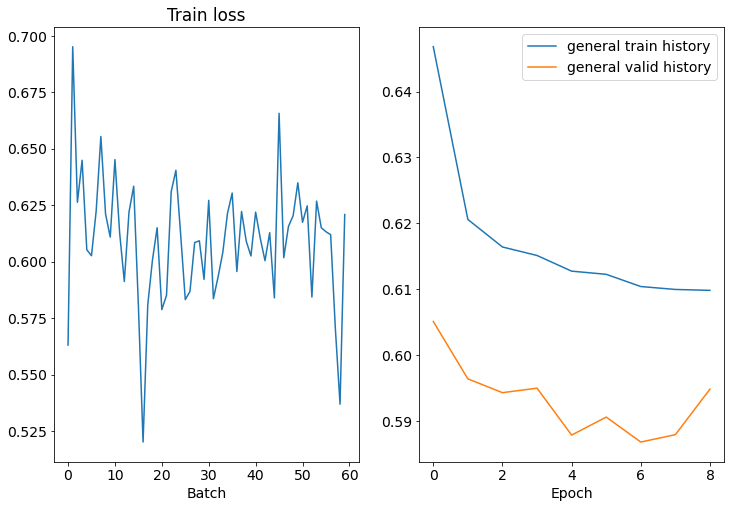

Epoch: 10 | Time: 0m 10s
	Train Loss: 0.609 | Train PPL:   1.839
	 Val. Loss: 0.585 |  Val. PPL:   1.794


In [210]:
N_EPOCHS = 10
CLIP = 1

def train(use_class_weights, N_EPOCHS, CLIP, lr=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr)
    if use_class_weights:
        # weights depend on the number of objects of class 0 and 1
        # YOUR CODE
        zeros = 0
        ones = 0
        for batch in train_iterator:
            zeros += (batch['outputs'] == 0).sum()
            ones += (batch['outputs'] == 1).sum()
        # веса обратно пропорционально вхождению метов в тренировочный датасет
        weights = torch.tensor([1 / zeros / (zeros + ones), 1 / ones / (zeros + ones)]).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=2)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=2)
    train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

train(True, N_EPOCHS, CLIP)

## Inference

In [211]:
from train_model import punct_detokenize, postprocess

def inference_summarunner(model, iterator, top_k=3):

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:

        logits = model(batch['inputs'])
        sum_in = torch.argsort(logits, dim=1)[:, -top_k:]
        
        for i in range(len(batch['outputs'])):

            summary = batch['records'][i]['summary'].lower()
            pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i]])

            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    calc_scores(references, predictions)

model.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: с 1 января 2020 года whatsapp прекращает поддержку смартфонов с устаревшими версиями android и ios , а также всех гаджетов на базе windows phone . администрация мессенджера заявила , что будет заниматься поддержкой только тех ос , которые являются широко распространенными среди пользователей , постепенно отключая несовременные устройства от своей сети .
Hyp: начиная с 2020 года , мессенджер whatsapp перестанет работать у миллионов пользователей по всему миру , сообщает daily mail . так , с 1 января сервис станет недоступным для всех владельцев телефонов на базе windows phone — известно , что в этот же день microsoft прекращает поддержку windows 10 mobile os . кроме того , с 1 февраля 2020 года поддержки лишатся устройства на базе ios версии 8 или старше , а также телефоны с android 2.3.7 или старше .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.3173318124753692, 'p': 0.3031341514395034, 'r': 0.3531967563454292}, 'rouge-2': {'f': 0.14277322190268435, 'p': 0.1347

Добавим второй вид inference с отбором логитов > thh. Логиты, которые возвращает модель могут быть отрицательными, поэтому порог может быть < 0.

In [221]:
def inference_summarunner_trh(model, iterator, trh=0.1):

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:
        logits = model(batch['inputs'])
        for i in range(len(batch['outputs'])):
            l = logits[i][batch['outputs'][i] != 2]
            sum_in = (l > trh).nonzero().squeeze(dim=1)

            summary = batch['records'][i]['summary'].lower()
            pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort()[0]])

            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    calc_scores(references, predictions)

## Модель с весовами лосса и без novelty

Посчитаем оба инференса. Значения k=3 и trh=0.387 найдены перебором, сам код перебора приводить не стал, т.к. много вывода в консоль, но идея простая. По k понятно как, взял то значение, на котором функция bleu имела локальный максимимум. Для trh перебрал сначала десятые доли, нашел максимум, потом сотые с фиксированным значением десятых, потом тысячные. Можно было бы заморочиться и подбирать дальше, но кажется, что полученное значение достаточно неплохое, а дальнейшие расчеты весьма трудоемки.

In [245]:
model.load_state_dict(torch.load('best-val-model.pt'))

<All keys matched successfully>

In [246]:
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: жители многих регионов россии могут ждать теплой погоды в ноябре , рассказали в гидрометцентре . в следующем месяце столбики термометров будут подниматься выше среднестатистических значений в европейской части россии , а также в северных регионах страны и в приморье . не станет исключением из общей тенденции и москва .
Hyp: в европейской части россии , а также в северных регионах страны грядущий ноябрь окажется теплее , чем обычно – приводит « российская газета » слова заведующей лабораторией гидрометцентра рф людмилы паршиной . в следующем месяце столбики термометров будут подниматься выше среднестатистических значений в ленинградской , псковской , новгородской , вологодской областях , в также в поволжье , в регионах центрального федерального округа , в большинстве южных территорий , передает фан . такое же явление ожидается в мурманской области , карелии , архангельской области .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.317331812475369, 'p': 0.30313415143

In [253]:
inference_summarunner_trh(model, test_iterator, trh=0.387)

Count: 256
Ref: после избиения учеников в одной из коррекционных школ москвы на преподавательницу завели уголовное дело . в полицию ранее обратилась мать одного из пострадавших школьников . тем временем после того , как педагога поместили под подписку о невыезде в рамках расследования , она подала встречный иск на родителей школьников . по ее мнению , они установили в кабинете скрытые камеры , хотя не имели на это права .
Hyp: на педагога одной из коррекционных школ москвы завели уголовное дело по факту избиения ребенка — женщина находится под подпиской о невыезде . об этом сообщила официальный представитель мвд ирина волк . как уточнили в ведомстве , в полицию обратилась 40-летняя жительница москвы — она заявила , что к ее 11-летнего сыну жестоко относится учитель .
BLEU:  0.4939739913783926
ROUGE:  {'rouge-1': {'f': 0.3225667597640449, 'p': 0.3365818603846569, 'r': 0.32754595467348807}, 'rouge-2': {'f': 0.14888362806685354, 'p': 0.15669422135644878, 'r': 0.15253606195133368}, 'rouge-

## Модель без весов лосса и без novelty

In [315]:
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)

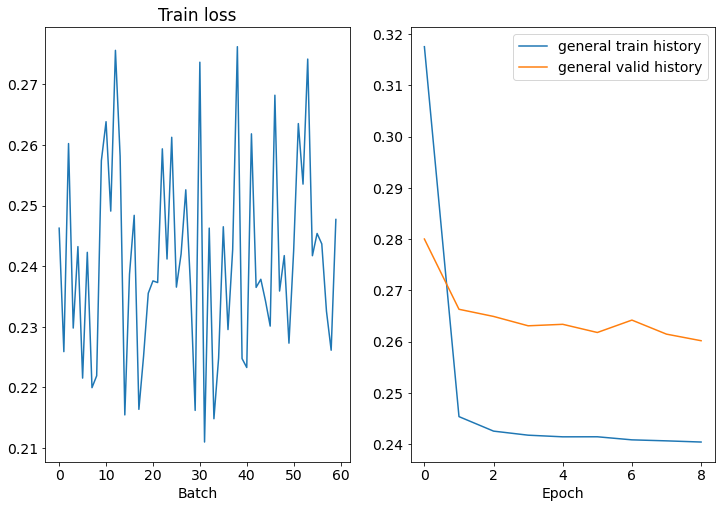

Epoch: 10 | Time: 0m 9s
	Train Loss: 0.241 | Train PPL:   1.272
	 Val. Loss: 0.266 |  Val. PPL:   1.305


In [316]:
train(False, N_EPOCHS, CLIP)

In [317]:
model.load_state_dict(torch.load('best-val-model.pt'))

<All keys matched successfully>

In [318]:
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: для борьбы с с недобросовестными азс , недоливающими топливо , будут использоваться специальные приборы , а также проверки программного обеспечения . в этом вопросе росстандарт намерен использовать опыт , полученный в сфере регулирования работы игровых автоматов .
Hyp: росстандарт готовит арсенал для проверок автозаправочных станций на недолив топлива : проверяться будет не конкретная колонка , а ее работа как системы , в том числе ее связь с оператором за кассой . контролеров при работе методом тайного покупателя вооружат скрытым прибором , который сможет « ловить » недолив на уровне 1 % . кроме того , новый гост защитит топливораздаточные колонки от приспособлений и вредоносного по , обманывающих расходомер .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.31733181247536896, 'p': 0.3031341514395032, 'r': 0.35319675634542935}, 'rouge-2': {'f': 0.14277322190268432, 'p': 0.13475932187114892, 'r': 0.16339726182715178}, 'rouge-l': {'f': 0.2715462303275749, 'p': 0.273

In [330]:
inference_summarunner_trh(model, test_iterator, trh=-0.801)

Count: 256
Ref: владимир путин призвал свести к минимуму возможность умаления прав человека в новых законах . по его словам , законопроекты должны соответствовать мировым стандартам в сфере прав и свобод человека . кроме того , президент отметил важную роль конституционного суда как надежного хранителя конституционного порядка .
Hyp: президент россии владимир путин призвал российских законодателей не отступать от мировых стандартов в сфере прав и свобод человека при принятии новых законов . по его словам , закон — это практически всегда компромисс интересов . « важно , чтобы законодатели не отступали от общепризнанных мировых стандартов в сфере защиты прав и свобод человека » , — сказал путин на встрече с судьями конституционного суда россии .
BLEU:  0.46045419595826254
ROUGE:  {'rouge-1': {'f': 0.31967505471269075, 'p': 0.31536232412656723, 'r': 0.3454463636478736}, 'rouge-2': {'f': 0.14496002214725412, 'p': 0.14285609172853767, 'r': 0.15990702354627767}, 'rouge-l': {'f': 0.2732679721

В данном кейсе получилось, что лучшее значение получается при k = 3 (на самом деле обе модели смотрят только на первые 3 слова), а значение trh=-0.801. Интересно, что модель без весов очень из-за несбалансированности классов плохо определяет класс 1, поэтому значение порога отрицательно (в принципе ни одному из предложений в тестовом датасете модель не ванговала положительный логит).

## Модель с весами и novelty

Поскольку модель с весами показала себя сильно лучше, попробуем добавить к ней novelty и посмотрим, как изменится качество предикта.

In [355]:
model = SentenceTaggerRNN(vocab_size, use_novelty=True).to(device)

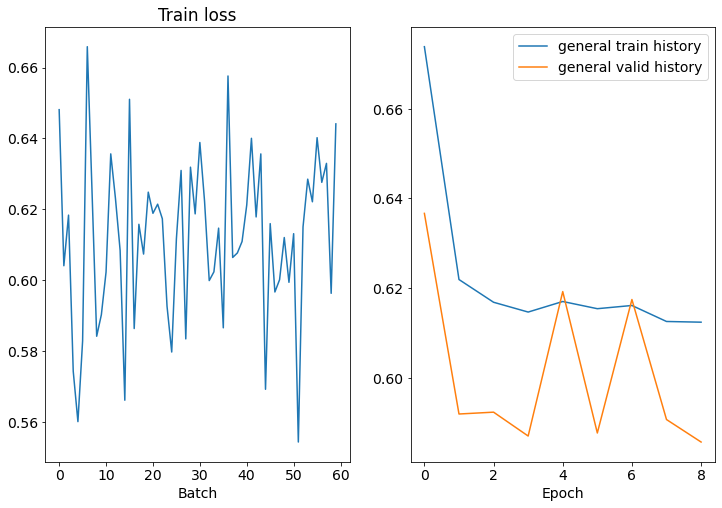

Epoch: 10 | Time: 0m 19s
	Train Loss: 0.611 | Train PPL:   1.842
	 Val. Loss: 0.589 |  Val. PPL:   1.802


In [356]:
train(True, N_EPOCHS, CLIP)

In [357]:
model.load_state_dict(torch.load('best-val-model.pt'))

<All keys matched successfully>

In [358]:
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: китайские власти собирают большое количество информации о жителях страны , создавая огромные базы данных с подробностями жизни каждого гражданина . теперь современные технологии помогают им отправлять людей с подозрением на коронавирус в карантин , присваивая каждому пользователю цвет , соответствующий их состоянию здоровья . впрочем , эта система не совершенна — некоторые китайцы получили « красный код » , не имея никаких симптомов , и теперь не знают , как от него избавиться и покинуть карантин .
Hyp: в китае проводится массовый эксперимент по использованию мобильной системы для определения состояния здоровья граждан , сообщает new york times . приложение под названием alipay health code уже активно используется в 200 городах страны и постепенно распространяется на всю кнр . граждан заставляют устанавливать на свои смартфоны программу , которая назначает им цветовой код — зеленый , желтый или красный — в зависимости от их состояния здоровья .
BLEU:  0.4483358093852308

In [374]:
inference_summarunner_trh(model, test_iterator, trh=0.445)

Count: 256
Ref: австралиец саймон доранте-дэй , уверенный , что он непризнанный внебрачный сын принца чарльза и камиллы паркер-боулз , решил потребовать признание этого факта через верховный суд австралии . он пытается доказать , что наследник британского престола и его супруга — его настоящие родители . накануне , 27 января , бельгийке дельфин боэль удалось добиться подтверждения отцовства бывшего короля бельгии альберта ii — ей помог тест днк , который экс-монарх согласился пройти .
Hyp: австралиец британского происхождения саймон доранте-дэй , считающий себя непризнанным внуком королевы елизаветы ii , хочет заставить принца чарльза и его супругу камиллу сдать днк для анализа — он надеется , что экспертиза докажет , что они его родители . об этом сообщает таблоид daily mail .
BLEU:  0.4846199352580925
ROUGE:  {'rouge-1': {'f': 0.31681427613168356, 'p': 0.3353896752836415, 'r': 0.3224302130256059}, 'rouge-2': {'f': 0.14535456776661038, 'p': 0.15573181454154872, 'r': 0.1498028005984721

## Вывод:

Лучший результат получился у модели со взвешенным лоссом и без novelty, с инференсом при значении порога trh=0.387. Финальное значение BLEU=0.4939739913783926. Интересно, что такая же модель с добавлением novelty показала себя хуже (порог trh=0.445 и BLEU=0.4846199352580925), возможно модели не хватило эпох для обучения. Инференс с сортировкой всегда дает одинаковое значение BLEU=0.4846199352580925 при k=3, другие значения k ухудшают значение метрики. 